<a href="https://colab.research.google.com/github/A01364577/Equipo_18_Navegacion_Autonoma/blob/main/Actividad_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maestria en Inteligencia Artificial Aplicada
##Navegación Autónoma
###Actividad 4.1 - Ejercicio de clasificación con Keras
Equipo 18:

- Laura Irán González Ojeda - A01794099
- Emmanuel Francisco González Velázquez - A01364577
- Fabiola Sosa Hernández- A01240145
- Jorge Fernández Lara - A01793062
- Jonathan Puga Castellanos - A01795204

In [1]:
#importar librerías
import json
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Verificar si el sistema operativo es Windows o macOS
if os.name == 'nt' or os.name == 'posix':
    # Cerrar todas las ventanas de OpenCV
    cv2.destroyAllWindows()

In [3]:
# Descargar y descomprimir el dataset de Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"<YOUR_KAGGLE_USERNAME>","key":"<YOUR_KAGGLE_KEY>"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip -d /content/gtsrb-german-traffic-sign


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00010.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00011.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00012.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00013.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00014.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00015.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00016.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00017.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00018.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00019.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/00005_00053_00020.png  
  inflating: /content/gtsrb-german-traffic-sign/train/5/000

In [4]:
# Definir la ruta del dataset
train_csv_path = '/content/gtsrb-german-traffic-sign/Train.csv'
test_csv_path = '/content/gtsrb-german-traffic-sign/Test.csv'
train_image_dir = '/content/gtsrb-german-traffic-sign/Train'
test_image_dir = '/content/gtsrb-german-traffic-sign/Test'

In [23]:
# Cargar el archivo CSV de entrenamiento
train_csv_path = '/content/gtsrb-german-traffic-sign/Train.csv'
train_data = pd.read_csv(train_csv_path)

# Mostrar las primeras filas del DataFrame
print(train_data.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [24]:
# Cargar el archivo CSV de prueba
test_csv_path = '/content/gtsrb-german-traffic-sign/Test.csv'
test_data = pd.read_csv(test_csv_path)

# Mostrar las primeras filas del DataFrame
print(test_data.head())

# Mostrar las rutas de las imágenes
print("Rutas de imágenes en el CSV de prueba:")
for path in test_data['Path'].head(10):
    print(path)

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
Rutas de imágenes en el CSV de prueba:
Test/00000.png
Test/00001.png
Test/00002.png
Test/00003.png
Test/00004.png
Test/00005.png
Test/00006.png
Test/00007.png
Test/00008.png
Test/00009.png


In [41]:
# Función para cargar las imágenes y etiquetas desde los archivos CSV
def load_images_from_csv(csv_path, base_dir):
    data = pd.read_csv(csv_path)
    images = []
    labels = []
    for index, row in data.iterrows():
        img_path = os.path.join(base_dir, row['Path'])

        if 'Train' in img_path:
            sub_dir = row['Path'].split('/')[1]  # Obtener el subdirectorio (0, 1, ..., 42)
            img_path = os.path.join(base_dir, sub_dir, row['Path'].split('/')[-1])
        elif 'Test' in img_path:
            img_path = os.path.join(base_dir, row['Path'].split('/')[-1])

        # Ajustar la ruta en caso de duplicados
        if not os.path.exists(img_path):
            img_path = os.path.join(base_dir, os.path.basename(img_path))

        if not os.path.exists(img_path):
            print(f"Archivo no encontrado: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"No se pudo cargar la imagen: {img_path}")
            continue

        img = cv2.resize(img, (32, 32))  # Redimensionar a 32x32 píxeles
        images.append(img)
        labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

In [42]:
# Cargar las imágenes y etiquetas de entrenamiento y prueba
X_train, y_train = load_images_from_csv(train_csv_path, train_image_dir)
X_test, y_test = load_images_from_csv(test_csv_path, test_image_dir)

In [43]:
# Verificar las dimensiones de los datos cargados
print("Dimensiones de las imágenes cargadas:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Dimensiones de las imágenes cargadas:
X_train: (39209, 32, 32, 3)
y_train: (39209,)
X_test: (12630, 32, 32, 3)
y_test: (12630,)


In [44]:
# Normalizar las intensidades de los píxeles en un rango de [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [45]:
# Convertir las etiquetas a one-hot encoding
num_classes = len(np.unique(y_train))  # Número de clases
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [46]:
# Definir el modelo de la red neuronal convolucional
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

In [47]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Resumen del modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                        

In [49]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1103/1103 [==============================] - 202s 180ms/step - loss: 0.8812 - accuracy: 0.7424 - val_loss: 22.2466 - val_accuracy: 0.0273
Epoch 2/10
1103/1103 [==============================] - 198s 180ms/step - loss: 0.1423 - accuracy: 0.9554 - val_loss: 19.6338 - val_accuracy: 0.0283
Epoch 3/10
1103/1103 [==============================] - 202s 183ms/step - loss: 0.0812 - accuracy: 0.9757 - val_loss: 20.3638 - val_accuracy: 0.0283
Epoch 4/10
1103/1103 [==============================] - 202s 183ms/step - loss: 0.0624 - accuracy: 0.9805 - val_loss: 26.9265 - val_accuracy: 0.0283
Epoch 5/10
1103/1103 [==============================] - 201s 182ms/step - loss: 0.0512 - accuracy: 0.9845 - val_loss: 29.8605 - val_accuracy: 0.0283
Epoch 6/10
1103/1103 [==============================] - 198s 180ms/step - loss: 0.0446 - accuracy: 0.9866 - val_loss: 29.4162 - val_accuracy: 0.0283
Epoch 7/10
1103/1103 [==============================] - 200s 181ms/step - loss: 0.0414 - accuracy: 0.9876 

In [50]:
# Evaluar el modelo en el conjunto de prueba
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

395/395 [==============================] - 18s 46ms/step - loss: 3.1743 - accuracy: 0.8785
Test loss: 3.1743171215057373
Test accuracy: 0.8784639835357666


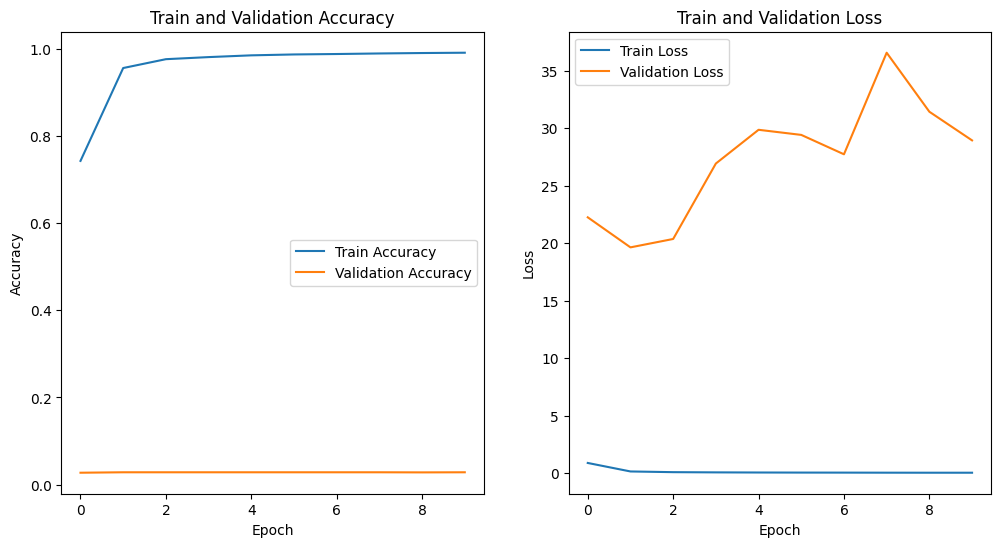

In [51]:
# Visualizar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [52]:
# Guardar el modelo
model.save("traffic_sign_classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


395/395 [==============================] - 24s 59ms/step


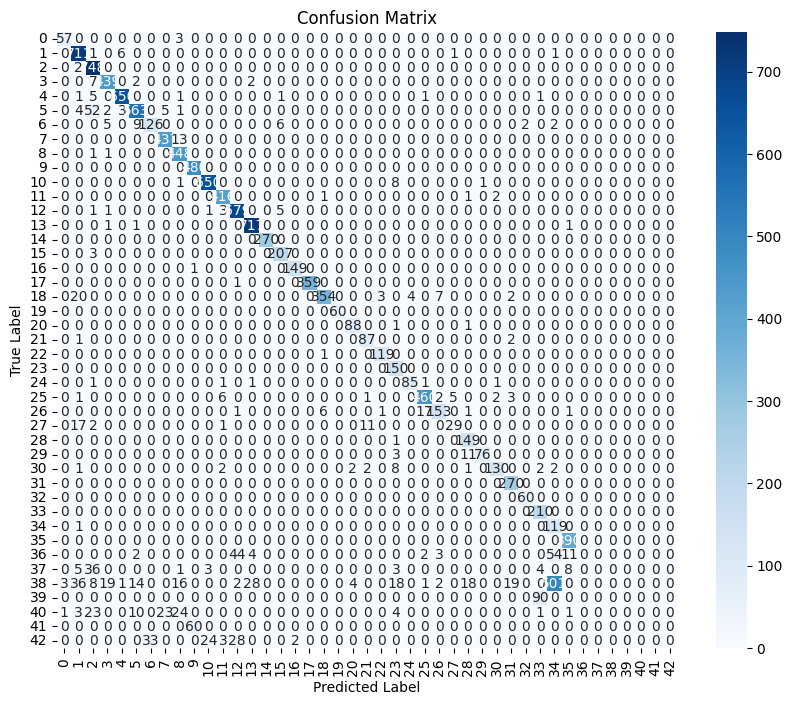

In [54]:
from sklearn.metrics import confusion_matrix

# Predicciones y matriz de confusión
preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()